In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

In [40]:
! apt install tesseract-ocr
! apt install libtesseract-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (5,307 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../tesserac

In [43]:
! pip install Pillow
! pip install pytesseract

     |████████████████████████████████| 4.3 MB 24.5 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [44]:
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


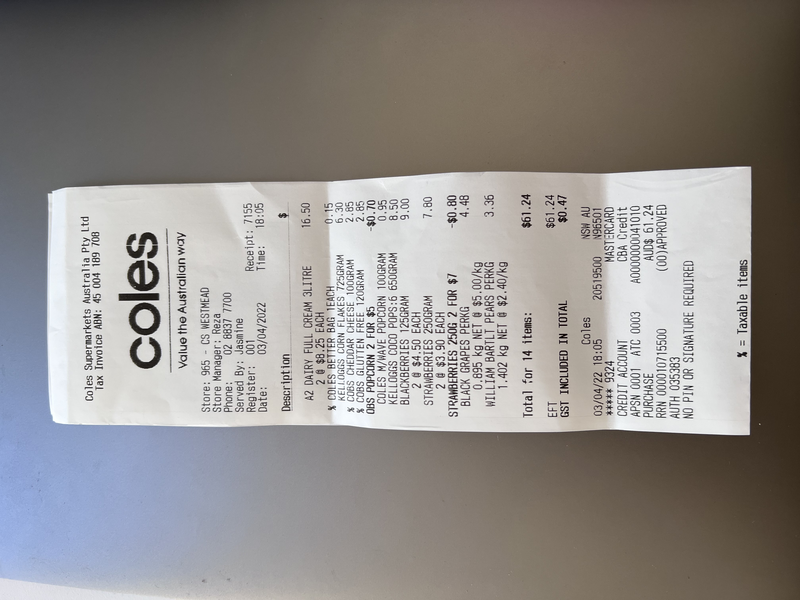

In [19]:
# Sample file out of the dataset
file_name = '/content/drive/MyDrive/OCR/IMG-1226.jpg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [20]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [21]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [22]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [23]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

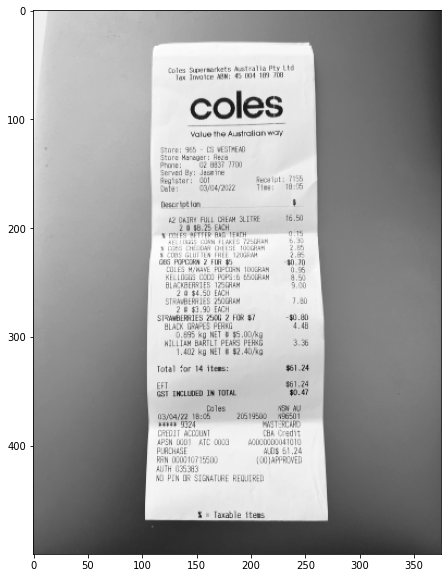

In [24]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

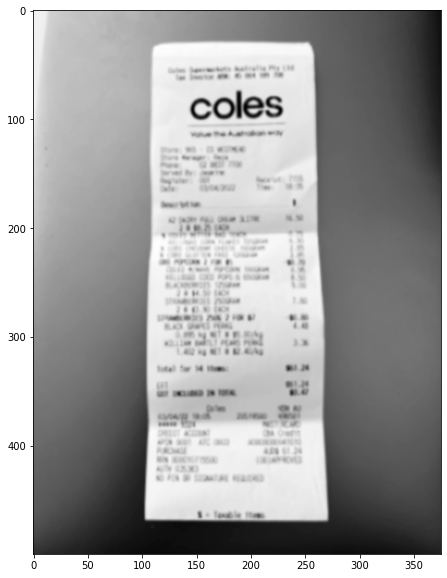

In [25]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

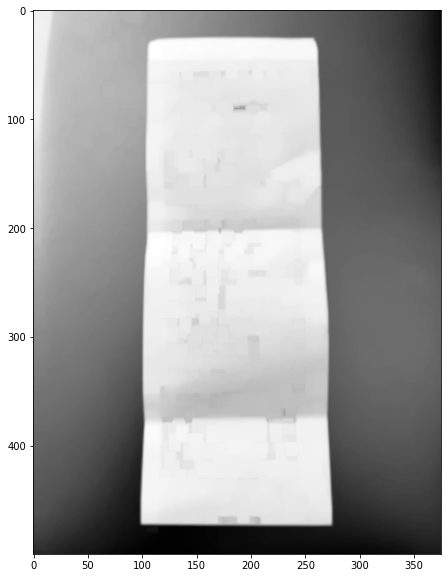

In [26]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

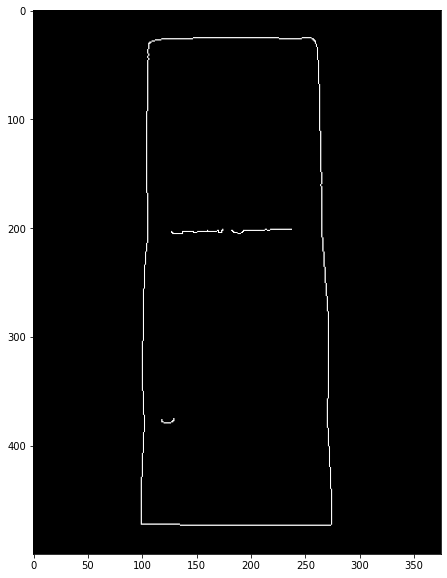

In [27]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

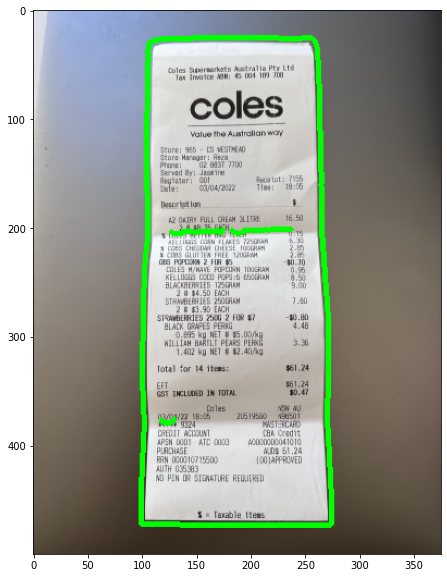

In [28]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

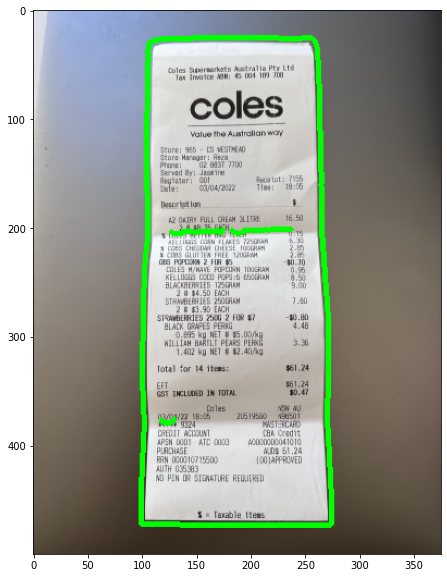

In [29]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [30]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [31]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [32]:
get_receipt_contour(largest_contours)

array([[[109,  28]],

       [[ 99, 472]],

       [[273, 473]],

       [[259,  28]]], dtype=int32)

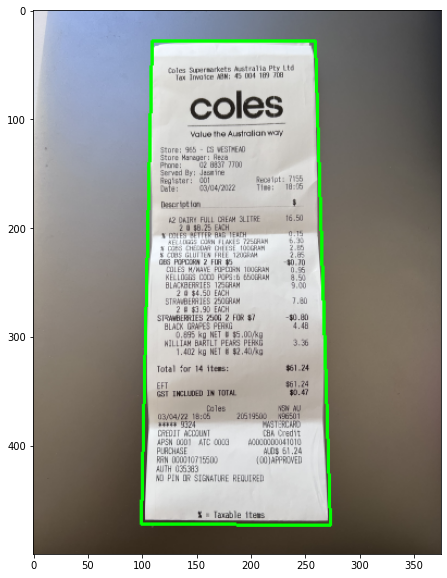

In [33]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [34]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [35]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

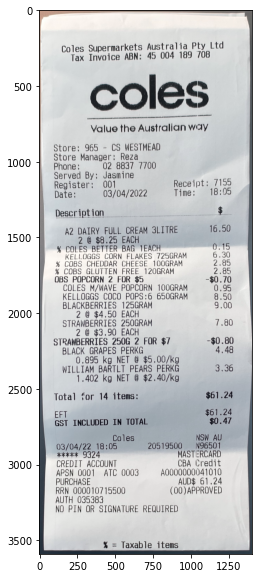

In [36]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [37]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

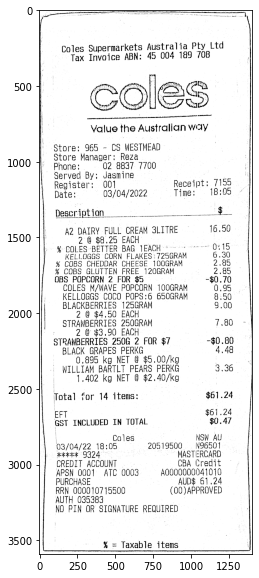

In [47]:
result = bw_scanner(scanned)
image = bw_scanner(scanned)
plot_gray(result)

In [48]:
output = Image.fromarray(result)
output.save('result.png')

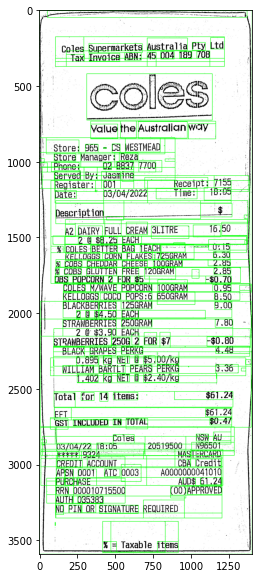

In [49]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [50]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

RCH
~ RRN 000010718800

 

“Coles Supermarkets Australia Pty Ltd
Tax Invoice ABN: 45 004 189 708

 

Value the Australian way

Store: 965 - CS WESTMEAD -

; Store Manager: Reza | a
}' Phone: 02 8837 7700
Served By: Hagin tne

Register: Receipt: 7155

Date: - 03/04/2022 Times 18:05
bescription _ eer 2 ;
A2 DAIRY. FULL CREAM SLITRE 16. 50
| 8,25 EACH a -
oe coves. BETTER BAG JEACH=0 ~~ O15
KELLOGGS CORN FLAKES: ST OBGRAM 6.30
% COBS CHEDDAR CHEESE 100GRAM 2.85 |
% COBS GLUTTEN hs 1Z0GRAM a 2.85 |
OBS POPCORN 2 FOR $5 ~$0.70

COLES M/WAVE POPCORN 100GRAM 0.95 |

KELLOGGS COCO POPS:6 B50GRAM 8.50

BLACKBER TES 125GRAM 9.00
2 @ $4.50 EACH |
| aa 250GRAM 7.80
STRAWBERRIES. 2506 2 FOR $7 | -$0.80
BLACK GRAPES PERKG 4.48.
: 0,895 kg NET @ $5. 00/kg 7m
+ WILLTAM BARTLT PEARS PERKG ~ 3.36 |
1.402 kg NET @ $2.40/kg :
Total For 14 items: — $61.24
EFT $61.24
GST INCLUDED IN TOTAL $0.47

| | Coles NSW AU
| 03/04/22 18:05 20519500, /NOB5O1-.

fe RR OBZ WS TERCARD
CREDIT ACCOUNT A Credit
pr eh OE ATC.

In [51]:
#extracting grand total
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [52]:
amounts = find_amounts(extracted_text)
amounts

[6.3, 2.85, 0.7, 0.95, 8.5, 9.0, 4.5, 7.8, 0.8, 4.48, 3.36, 2.4, 61.24, 0.47]

In [53]:
max(amounts)

61.24

In [55]:
#Lines to excluse on the receipt
exclusion_list = ["bank", "total", "promo", "vat", "change", "recyclable"]

#Words to ommit
remove_list = ["vit", "etc"]

In [54]:
#Extract letters and numbers regex
regex_line = []
for line in extracted_text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['| 8,25 EACH a -', 'KELLOGGS CORN FLAKES: ST OBGRAM 6.30', '% COBS CHEDDAR CHEESE 100GRAM 2.85 |', '% COBS GLUTTEN hs 1Z0GRAM a 2.85 |', 'OBS POPCORN 2 FOR $5 ~$0.70', 'COLES M/WAVE POPCORN 100GRAM 0.95 |', 'KELLOGGS COCO POPS:6 B50GRAM 8.50', 'BLACKBER TES 125GRAM 9.00', '2 @ $4.50 EACH |', '| aa 250GRAM 7.80', 'STRAWBERRIES. 2506 2 FOR $7 | -$0.80', 'BLACK GRAPES PERKG 4.48.', ': 0,895 kg NET @ $5. 00/kg 7m', '+ WILLTAM BARTLT PEARS PERKG ~ 3.36 |', '1.402 kg NET @ $2.40/kg :', 'Total For 14 items: — $61.24', 'EFT $61.24', 'GST INCLUDED IN TOTAL $0.47', 'UD$ 61.24']


In [56]:
#Apply exclusion list
food_item = []
for eachLine in regex_line:
    found = False
    for exclude in exclusion_list:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        food_item.append(eachLine)
print(food_item)

['| 8,25 EACH a -', 'KELLOGGS CORN FLAKES: ST OBGRAM 6.30', '% COBS CHEDDAR CHEESE 100GRAM 2.85 |', '% COBS GLUTTEN hs 1Z0GRAM a 2.85 |', 'OBS POPCORN 2 FOR $5 ~$0.70', 'COLES M/WAVE POPCORN 100GRAM 0.95 |', 'KELLOGGS COCO POPS:6 B50GRAM 8.50', 'BLACKBER TES 125GRAM 9.00', '2 @ $4.50 EACH |', '| aa 250GRAM 7.80', 'STRAWBERRIES. 2506 2 FOR $7 | -$0.80', 'BLACK GRAPES PERKG 4.48.', ': 0,895 kg NET @ $5. 00/kg 7m', '+ WILLTAM BARTLT PEARS PERKG ~ 3.36 |', '1.402 kg NET @ $2.40/kg :', 'EFT $61.24', 'UD$ 61.24']


In [57]:
#Word ommit
new_food_item_list = []
for item in food_item:
    for subToRemove in remove_list:
        item = item.replace(subToRemove, "")
        item = item.replace(subToRemove.upper(), "")
    new_food_item_list.append(item)
print(new_food_item_list)

['| 8,25 EACH a -', 'KELLOGGS CORN FLAKES: ST OBGRAM 6.30', '% COBS CHEDDAR CHEESE 100GRAM 2.85 |', '% COBS GLUTTEN hs 1Z0GRAM a 2.85 |', 'OBS POPCORN 2 FOR $5 ~$0.70', 'COLES M/WAVE POPCORN 100GRAM 0.95 |', 'KELLOGGS COCO POPS:6 B50GRAM 8.50', 'BLACKBER TES 125GRAM 9.00', '2 @ $4.50 EACH |', '| aa 250GRAM 7.80', 'STRAWBERRIES. 2506 2 FOR $7 | -$0.80', 'BLACK GRAPES PERKG 4.48.', ': 0,895 kg NET @ $5. 00/kg 7m', '+ WILLTAM BARTLT PEARS PERKG ~ 3.36 |', '1.402 kg NET @ $2.40/kg :', 'EFT $61.24', 'UD$ 61.24']


In [58]:
#Food item cost regex
food_item_cost = []
for line in new_food_item_list:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            food_item_cost.append(possibleCost)
print(new_food_item_list)

['| 8,25 EACH a -', 'KELLOGGS CORN FLAKES: ST OBGRAM 6.30', '% COBS CHEDDAR CHEESE 100GRAM 2.85 |', '% COBS GLUTTEN hs 1Z0GRAM a 2.85 |', 'OBS POPCORN 2 FOR $5 ~$0.70', 'COLES M/WAVE POPCORN 100GRAM 0.95 |', 'KELLOGGS COCO POPS:6 B50GRAM 8.50', 'BLACKBER TES 125GRAM 9.00', '2 @ $4.50 EACH |', '| aa 250GRAM 7.80', 'STRAWBERRIES. 2506 2 FOR $7 | -$0.80', 'BLACK GRAPES PERKG 4.48.', ': 0,895 kg NET @ $5. 00/kg 7m', '+ WILLTAM BARTLT PEARS PERKG ~ 3.36 |', '1.402 kg NET @ $2.40/kg :', 'EFT $61.24', 'UD$ 61.24']


In [59]:
#Remove cost price from food item
count = 0;
only_food_items = []
for item in new_food_item_list:
    only_alpha = ""
    for char in item:
        if char.isalpha() or char.isspace():
            only_alpha += char
            
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    only_food_items.append(only_alpha)
print(only_food_items)

['EACH', 'KELLOGGS CORN FLAKES ST OBGRAM', 'COBS CHEDDAR CHEESE GRAM', 'COBS GLUTTEN hs ZGRAM', 'OBS POPCORN  FOR', 'COLES MWAVE POPCORN GRAM', 'KELLOGGS COCO POPS BGRAM', 'BLACKBER TES GRAM', 'EACH', 'aa GRAM', 'STRAWBERRIES   FOR', 'BLACK GRAPES PERKG', 'kg NET   kg', 'WILLTAM BARTLT PEARS PERKG', 'kg NET  kg', 'EFT', 'UD']


In [60]:
#Removes 2 letter words from food item
#No core food item has two letters (Most cases)
food = []
for item in only_food_items:
    # getting splits
    temp = item.split()

    # omitting K lengths
    res = [ele for ele in temp if len(ele) != 2]

    # joining result
    res = ' '.join(res)
    
    food.append(res)
print(food)

['EACH', 'KELLOGGS CORN FLAKES OBGRAM', 'COBS CHEDDAR CHEESE GRAM', 'COBS GLUTTEN ZGRAM', 'OBS POPCORN FOR', 'COLES MWAVE POPCORN GRAM', 'KELLOGGS COCO POPS BGRAM', 'BLACKBER TES GRAM', 'EACH', 'GRAM', 'STRAWBERRIES FOR', 'BLACK GRAPES PERKG', 'NET', 'WILLTAM BARTLT PEARS PERKG', 'NET', 'EFT', '']


In [61]:
#Taulate Food Item and Cost
t = PrettyTable(['Food Item', 'Cost'])
for counter in range (0,len(food)):
    t.add_row([food[counter], food_item_cost[counter]])
print(t)

+-----------------------------+-------+
|          Food Item          |  Cost |
+-----------------------------+-------+
|             EACH            |  8.25 |
| KELLOGGS CORN FLAKES OBGRAM |  6.30 |
|   COBS CHEDDAR CHEESE GRAM  |  2.85 |
|      COBS GLUTTEN ZGRAM     |  2.85 |
|       OBS POPCORN FOR       |  0.70 |
|   COLES MWAVE POPCORN GRAM  |  0.95 |
|   KELLOGGS COCO POPS BGRAM  |  8.50 |
|      BLACKBER TES GRAM      |  9.00 |
|             EACH            |  4.50 |
|             GRAM            |  7.80 |
|       STRAWBERRIES FOR      |  0.80 |
|      BLACK GRAPES PERKG     |  4.48 |
|             NET             | 0.895 |
|  WILLTAM BARTLT PEARS PERKG |  3.36 |
|             NET             | 1.402 |
|             EFT             |  2.40 |
|                             | 61.24 |
+-----------------------------+-------+
